## MNIST Classification with Pure Tensorflow
Although MNIST example has been tutorial for deep learning beginner, it is not easy as we might think. Especially for Tensorflow, many users have difficulty on applying MNIST examples to their domain problems. This is because Tensorflow provides tutorial-specific API for MNIST such as load data and batch extraction. Here, I tried to implement MNIST classification using pure python and tensorflow. If you want to be a professional developer without high-level API (such as Keras), I recommend this.

## Developer Information
- Sangjun Han
- LG CNS, South Korea
- written on 2018-09-27

In [1]:
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline

import tensorflow as tf

D:\ProgramData\Anaconda3\envs\tensorflow_python3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
num_classes = 10
width = height = 28

In [3]:
def shuffleData(data):
    idx = np.arange(0, data.shape[0])
    np.random.shuffle(idx)
    
    return data[idx]

### Data Load

In [4]:
# load data
data = pd.read_csv("./train.csv").values
data = shuffleData(data) # shuffle data

print("data shape :", data.shape)

data shape : (42000, 785)


### Split Data for Train and Validation Set
The validation set will be used for evaluating metrics when training.

In [5]:
def splitData(data, train_ratio=0.8):
    num_data = data.shape[0]
    num_train = int(num_data * train_ratio)
    
    train = data[:num_train]
    val = data[num_train:]
    
    return train, val

In [6]:
# split data train, val
x_train, x_val = splitData(data, 0.8)

print("x_train shape :", x_train.shape)
print("x_val shape :", x_val.shape)

x_train shape : (33600, 785)
x_val shape : (8400, 785)


In [7]:
# split label
y_train = x_train[:, 0]
x_train = x_train[:, 1:]

y_val = x_val[:, 0]
x_val = x_val[:, 1:]

print("x_train shape :", x_train.shape)
print("y_train shape :", y_train.shape)
print("x_val shape :", x_val.shape)
print("y_val shape :", y_val.shape)

x_train shape : (33600, 784)
y_train shape : (33600,)
x_val shape : (8400, 784)
y_val shape : (8400,)


In [8]:
# reshape
x_train = x_train.reshape([-1, width, height, 1]).astype("float32")
x_val = x_val.reshape([-1, width, height, 1]).astype("float32")

print("x_train shape :", x_train.shape)
print("x_val shape :", x_val.shape)

x_train shape : (33600, 28, 28, 1)
x_val shape : (8400, 28, 28, 1)


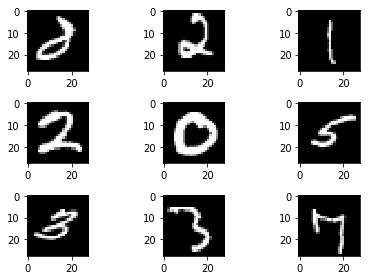

In [9]:
# plot data
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

### Data Augmentation
Using ImageDataGenerator in tf.keras, we generate augmented images from training and validation set.

In [10]:
def genAugmentedImg(img, label, num_data=10000):
    gen_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')
    
    gen_data.fit(x_train)
    data = gen_data.flow(img, label, batch_size=num_data)
    
    return data[0][0], data[0][1]

In [11]:
x_aug_train, y_aug_train = genAugmentedImg(x_train, y_train, 15000)
x_aug_val, y_aug_val = genAugmentedImg(x_val, y_val, 5000)

print("x_aug_train shape :", x_aug_train.shape)
print("y_aug_train shape :", y_aug_train.shape)

x_aug_train shape : (15000, 28, 28, 1)
y_aug_train shape : (15000,)


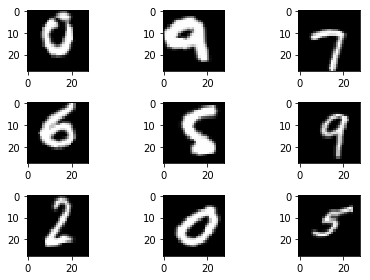

In [12]:
# plot data
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_aug_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [13]:
x_train = np.concatenate((x_train, x_aug_train, x_aug_val), axis=0)
y_train = np.concatenate((y_train, y_aug_train, y_aug_val), axis=0)

print("x_train shape :", x_train.shape)
print("y_train shape :", y_train.shape)

x_train shape : (53600, 28, 28, 1)
y_train shape : (53600,)


### Normalization

In [14]:
# normalization
x_train /= 255.0
x_val /= 255.0

print("x_train shape :", x_train.shape)
print("x_val shape :", x_val.shape)

x_train shape : (53600, 28, 28, 1)
x_val shape : (8400, 28, 28, 1)


### One-hot encoding for cross-entropy loss

In [15]:
def oneHotEncoding_sklearn(y):
    toLabel = LabelEncoder()
    toOneHot = OneHotEncoder()
    
    y = toLabel.fit_transform(y)
    y = y.reshape(-1, 1)
    y = toOneHot.fit_transform(y)
    
    return y.todense()

In [16]:
# one-hot encoding of label
y_train = oneHotEncoding_sklearn(y_train)
y_val = oneHotEncoding_sklearn(y_val)

print("y_train shape :", y_train.shape)
print("y_val shape :", y_val.shape)

y_train shape : (53600, 10)
y_val shape : (8400, 10)


### Deep Learning Blocks
I found that the combination of batch normalization with high dropout makes our performance worse extremely. I recommend you to apply only high dropout because of computation speed. Please discuss about their relationship.

In [17]:
def convBatchNormReluDropout(X, W, conv_stride=1, maxp_stride=2, prob=0.5, phase=True):
    H = tf.nn.conv2d(X, W, strides=[1, conv_stride, conv_stride, 1], padding='SAME')
    # H = tf.contrib.layers.batch_norm(H, is_training=phase, decay=0.9, zero_debias_moving_mean=True, center=True, scale=True, updates_collections=None)
    H = tf.nn.relu(H)
    H = tf.nn.dropout(H, prob)
    H = tf.nn.max_pool(H, ksize=[1, 2, 2, 1], strides=[1, maxp_stride, maxp_stride, 1], padding='SAME')
    print(H.shape[1:])
    
    return H

In [18]:
def flattenFC(X, W, input_size, prob=0.5, phase=True):
    H = tf.reshape(X, [-1, input_size])
    H = tf.matmul(H, W)
    # H = tf.contrib.layers.batch_norm(H, is_training=phase, decay=0.9, zero_debias_moving_mean=True, center=True, scale=True, updates_collections=None)
    H = tf.nn.relu(H)
    H = tf.nn.dropout(H, prob)
    print(H.shape[1:])
    
    return H

In [19]:
# model
print("model setting")
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1])
outputs = tf.placeholder(tf.float32, [None, 10])
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)
phase = tf.placeholder(tf.bool)

# he initializer
initializer = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False)
conv_stride = 1; maxp_stride = 2

# 1. conv block
W1 = tf.Variable(initializer([5, 5, 1, 32]))
H1 = convBatchNormReluDropout(inputs, W1, conv_stride, maxp_stride, keep_prob, phase)

# 2. conv block
W2 = tf.Variable(initializer([5, 5, 32, 64]))
H2 = convBatchNormReluDropout(H1, W2, conv_stride, maxp_stride, keep_prob, phase)

# 3. conv block
W3 = tf.Variable(initializer([5, 5, 64, 128]))
H3 = convBatchNormReluDropout(H2, W3, conv_stride, maxp_stride, keep_prob, phase)

flatten_size = int(H3.shape[1] * H3.shape[2] * H3.shape[3])

# 3. fc layers
W4 = tf.Variable(initializer([flatten_size, 128]))
H4 = flattenFC(H3, W4, flatten_size, keep_prob, phase)

# 4. fc layers
W5 = tf.Variable(initializer([128, 10]))
model = tf.matmul(H4, W5)
# model = tf.contrib.layers.batch_norm(H5, decay=0.9, zero_debias_moving_mean=True, is_training=phase, center=True, scale=True, updates_collections=None)
print(model.shape[1:])

# cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=outputs))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# accuracy
predict = tf.argmax(model, 1)
is_correct = tf.equal(predict, tf.argmax(outputs, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

model setting
(14, 14, 32)
(7, 7, 64)
(4, 4, 128)
(128,)
(10,)


### Training
Decaying learning rate when it was stuck may be effective on its performance.

In [20]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [21]:
# settings
lr = 0.001
epochs = 25
batch_size = 256
total_batch = int(x_train.shape[0] / batch_size)
patience = 0

In [22]:
# history
history = {}
history["train_loss_list"] = []
history["train_acc_list"] = []
history["val_loss_list"] = []
history["val_acc_list"] = []

In [23]:
def randomBatch(size, x, y): # randomly sample minibatch
    idx = np.arange(0, x.shape[0])
    np.random.shuffle(idx)
    idx = idx[:size]
    
    return x[idx], y[idx]

In [24]:
def nextBatch(size, x, y, idx): # iterablely sample minibatch
    sp = idx * size
    ep = (idx + 1) * size

    return x[sp:ep], y[sp:ep]

In [25]:
# training
print("Training Size:", x_train.shape[0])

for epoch in range(epochs):
    start_time = time()
    
    # training for update
    for i in range(total_batch):
        batch_x, batch_y = nextBatch(batch_size, x_train, y_train, i) # pick small batch
        sess.run([optimizer], feed_dict={inputs: batch_x, outputs: batch_y, learning_rate: lr, keep_prob: 0.5, phase: True}) # update
    
    # training evaluation
    batch_x, batch_y = randomBatch(x_val.shape[0], x_train, y_train) # pick random samples as much as validation size
    train_loss, train_acc = sess.run([cost, accuracy], feed_dict={inputs: batch_x, outputs: batch_y, keep_prob: 1, phase: False})
    
    # validation evaluation
    val_loss, val_acc = sess.run([cost, accuracy], feed_dict={inputs: x_val, outputs: y_val, keep_prob: 1, phase: False})
    
    # history
    history["train_loss_list"].append(train_loss)
    history["train_acc_list"].append(train_acc)
    history["val_loss_list"].append(val_loss)
    history["val_acc_list"].append(val_acc)
    
    # reduce lr when it was stuck (according to validation loss)
    if  epoch > 2 and (history["val_loss_list"][-2] < history["val_loss_list"][-1] or abs(history["val_loss_list"][-1] - history["val_loss_list"][-2]) < 0.01):
        patience += 1
        # decay learning rate when patience == 3
        if patience == 3:
            patience = 0
            lr *= 0.8
            print("------ Learning rate was decayed to %f" % lr)
    
    end_time = time() - start_time

    print("Epoch %d/%d (%ds) - train_loss: %0.3f, train_acc: %0.3f, val_loss: %0.3f, val_acc: %0.3f" % (epoch+1, epochs, end_time, train_loss, train_acc, val_loss, val_acc))

Training Size: 53600
Epoch 1/25 (111s) - train_loss: 0.659, train_acc: 0.949, val_loss: 0.580, val_acc: 0.960
Epoch 2/25 (111s) - train_loss: 0.346, train_acc: 0.974, val_loss: 0.286, val_acc: 0.978
Epoch 3/25 (110s) - train_loss: 0.203, train_acc: 0.984, val_loss: 0.167, val_acc: 0.986
Epoch 4/25 (110s) - train_loss: 0.178, train_acc: 0.985, val_loss: 0.145, val_acc: 0.986
Epoch 5/25 (110s) - train_loss: 0.147, train_acc: 0.984, val_loss: 0.115, val_acc: 0.988
Epoch 6/25 (110s) - train_loss: 0.114, train_acc: 0.990, val_loss: 0.092, val_acc: 0.992
Epoch 7/25 (110s) - train_loss: 0.111, train_acc: 0.992, val_loss: 0.090, val_acc: 0.993
Epoch 8/25 (114s) - train_loss: 0.104, train_acc: 0.992, val_loss: 0.082, val_acc: 0.993
Epoch 9/25 (116s) - train_loss: 0.082, train_acc: 0.993, val_loss: 0.066, val_acc: 0.993
Epoch 10/25 (115s) - train_loss: 0.075, train_acc: 0.992, val_loss: 0.055, val_acc: 0.994
------ Learning rate was decayed to 0.000800
Epoch 11/25 (111s) - train_loss: 0.078, tra

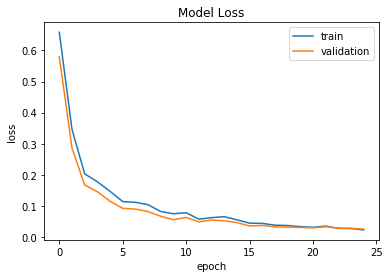

In [26]:
# plot loss
plt.plot(history["train_loss_list"])
plt.plot(history["val_loss_list"])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc=1),
plt.show()

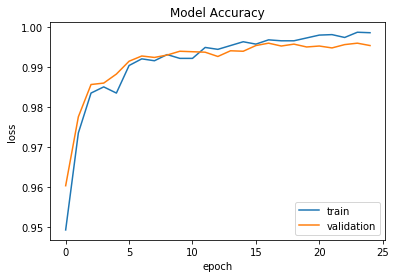

In [27]:
# plot loss
plt.plot(history["train_acc_list"])
plt.plot(history["val_acc_list"])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc=4),
plt.show()

### Test for Submission

In [28]:
# load for submission
x_test = pd.read_csv("./test.csv").values
x_test = x_test.reshape([-1, width, height, 1]).astype("float32")
x_test /= 255.0

submission = pd.read_csv("./sample_submission.csv")

print("x_test shape :", x_test.shape)

x_test shape : (28000, 28, 28, 1)


In [29]:
# test
predict_y = sess.run([predict], feed_dict={inputs: x_test, keep_prob: 1, phase: False})
submission["Label"] = predict_y[0]

In [30]:
# save
submission.to_csv("./my_submission.csv", index=False, header=True)